# PHT  - Value At Risk

***

## 1 Data Prep : 

### 1.1 Import packages :


~~~
install.packages('quantmod')
install.packages('fBasics')
install.packages('tseries')
install.packages('anytime')
install.packages('fGarch')
install.packages('rugarch')
install.packages('Rcpp')
install.packages('devtools')
install.packages('vctrs')
~~~

```{r}
require(quantmod)
library(tseries)
library(anytime)
library(fBasics)
library(rugarch)
library(fGarch)
library(Rcpp)
library(ggplot2)
```

### 1.2 data:

In [72]:
GAS <- read.csv("wGAS.csv", header=TRUE)

GAS$log_R <- Delt(GAS$Close, type = 'log')
GAS$return_norm <- Delt(GAS$Close, type = 'arithmetic')
GAS$neg_log_R = -GAS$log_R

GAS$Date <- anytime(GAS$Date)
GAS = GAS[-1, ]
head(GAS)

,X,Date,Close,log_R,return_norm,neg_log_R
,<int>,<dttm>,<dbl>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>"
2,1,2012-06-01,22.5331,-0.047252407,-0.046153390,0.047252407
3,2,2012-06-08,22.7148,0.008031355,0.008063693,-0.008031355
4,3,2012-06-15,22.4725,-0.010724355,-0.010667054,0.010724355
5,4,2012-06-22,23.3811,0.039635664,0.040431639,-0.039635664
6,5,2012-06-29,23.2600,-0.005192857,-0.005179397,0.005192857
7,6,2012-07-06,23.1994,-0.002608731,-0.002605331,0.002608731


## 2 Visualize:

### 2.1 Historical prices plot:

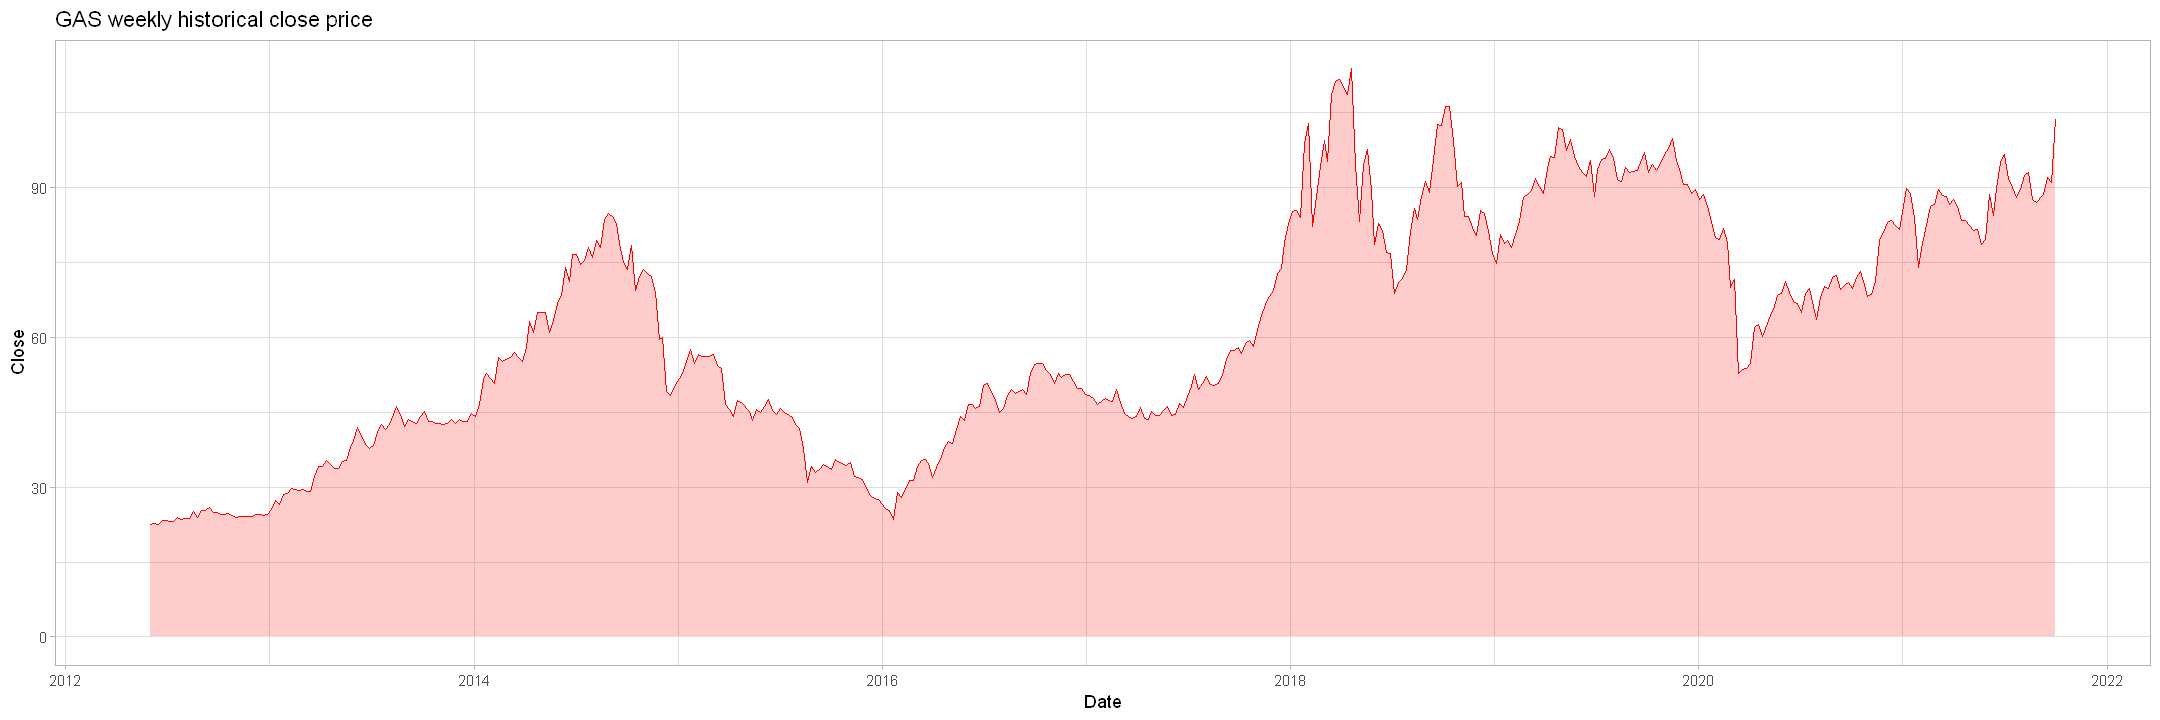

In [20]:
fig <- function(width, heigth){
     options(repr.plot.width = width, repr.plot.height = heigth)
}

fig(18,6)
ggplot(GAS, aes(x=Date, y=Close)) + geom_area(alpha = 0.2, color = 'red', fill="red") + 
    theme_light() + ggtitle("GAS weekly historical close price")

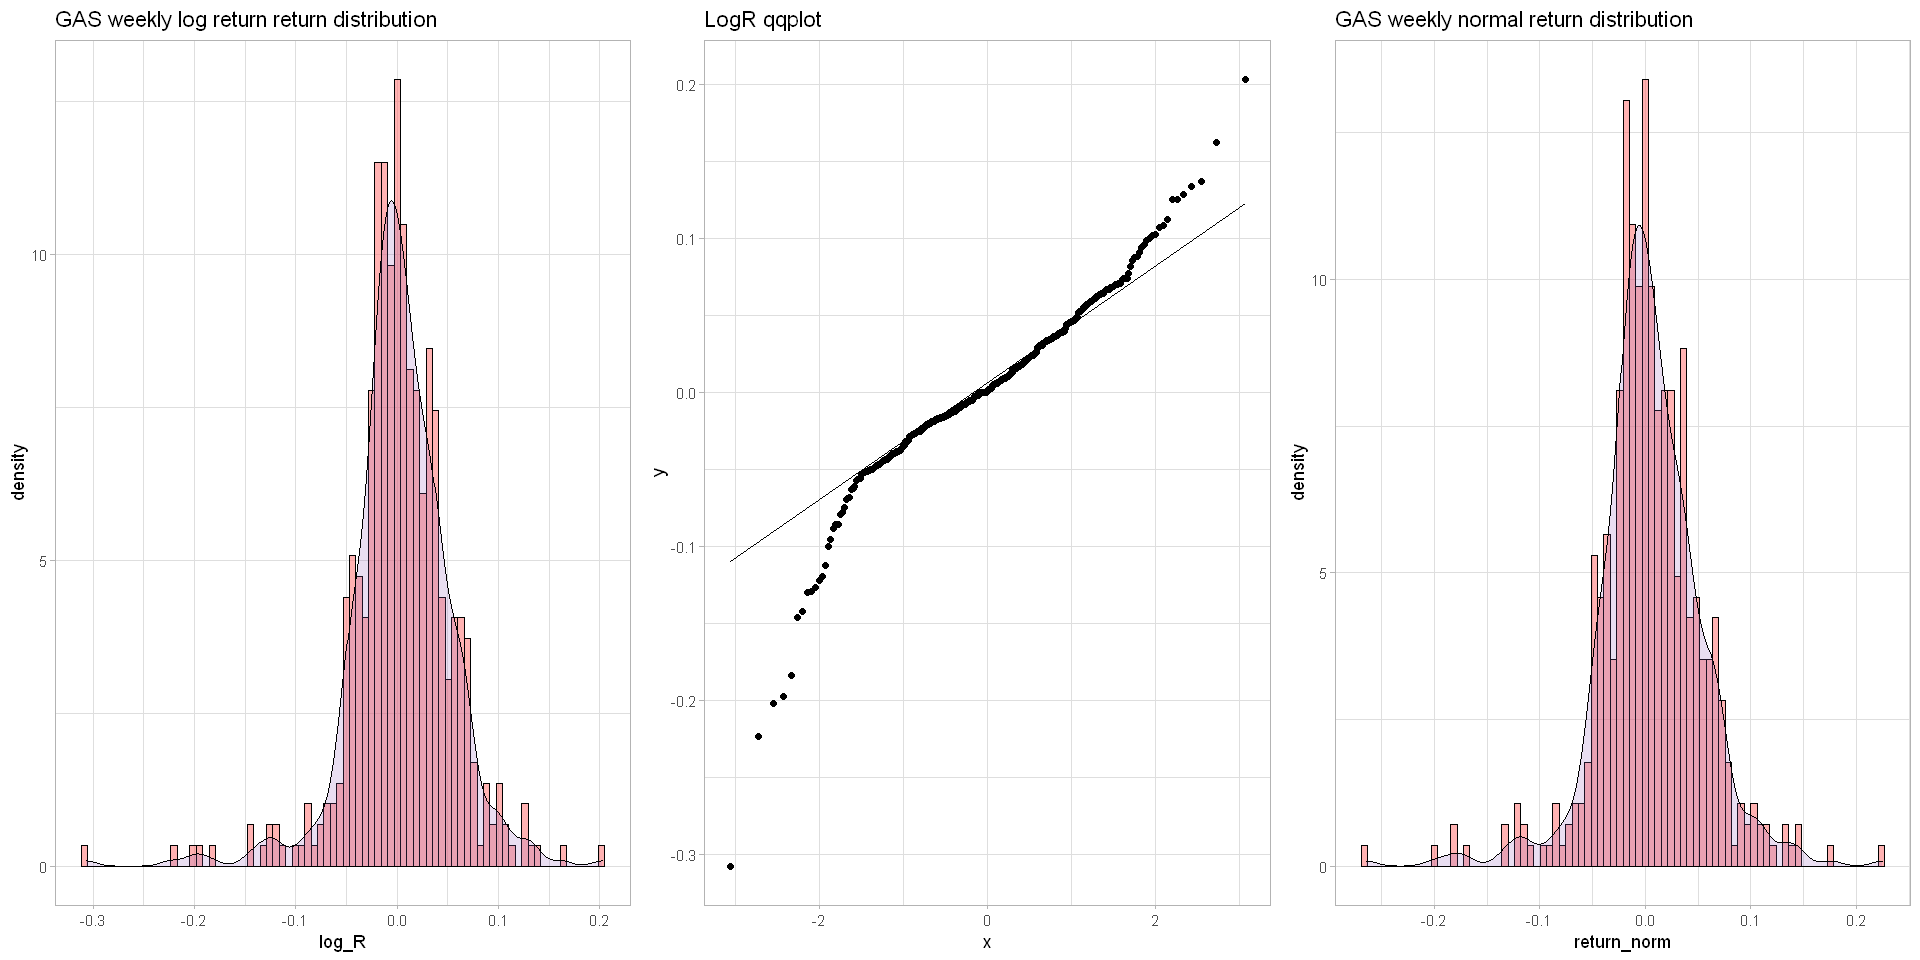

In [49]:
fig(16,8)
w1 <- ggplot(GAS, aes(x=log_R)) + 
 geom_histogram(aes(y=..density..), colour="black", alpha=0.5, fill='#FF6666', bins = 82)+
 geom_density(alpha=.2, fill="#905cb8") + theme_light() + ggtitle("GAS weekly log return return distribution")

w2 <- ggplot(GAS, aes(x=return_norm)) + 
 geom_histogram(aes(y=..density..), colour="black", alpha=0.5, fill='#FF6666', bins = 82)+
 geom_density(alpha=.2, fill="#905cb8") + theme_light() + ggtitle("GAS weekly normal return distribution")
 
w3 <- ggplot(GAS, aes(sample=log_R)) + stat_qq() + geom_qq_line() + theme_light() + ggtitle("LogR qqplot")
grid.arrange(w1 , w3 , w2, ncol = 3)

* line plot

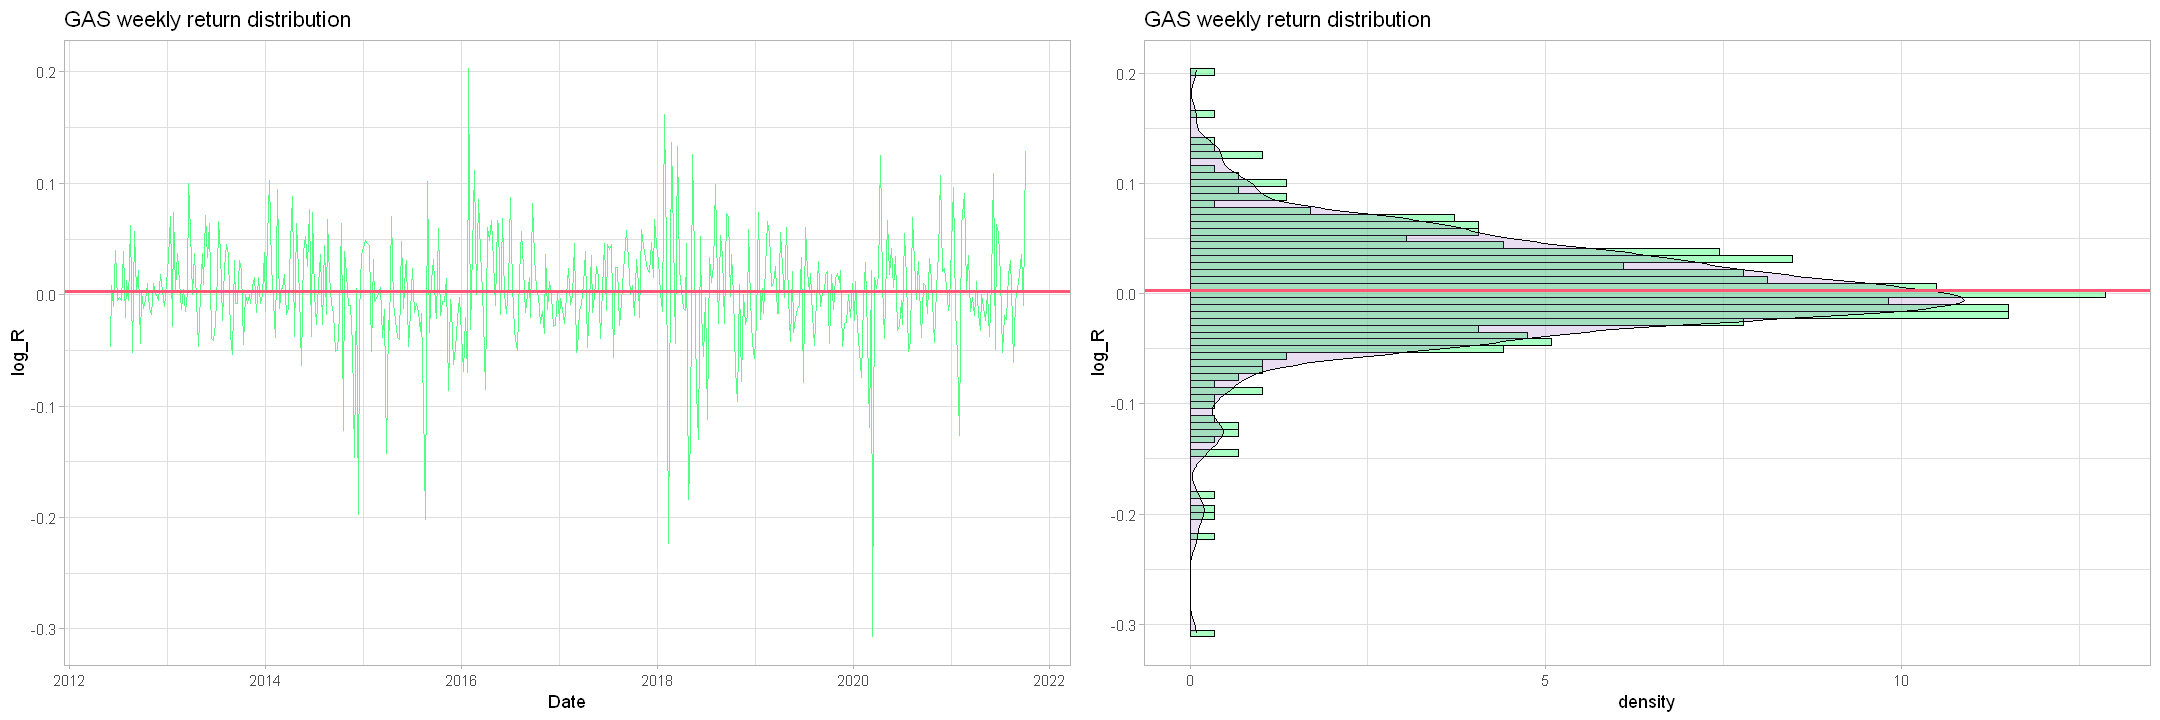

In [33]:
fig(18,6)
t1 <- ggplot(GAS, aes(x=Date)) + geom_line(aes(y = log_R),
                                color='#52ff83', alpha = 1) + geom_hline(yintercept = mean(GAS$log_R), 
                                color = '#ff5776' , size = 1) + theme_light() + ggtitle("GAS weekly return distribution")
                                
t2 <- ggplot(GAS, aes(x=log_R)) + 
 geom_histogram(aes(y=..density..), colour="black", alpha=0.5, fill='#52ff83', bins = 82)+
 geom_density(alpha=.2, fill="#905cb8") + coord_flip() + geom_vline(xintercept = mean(GAS$log_R ) , 
 color = '#ff5776' , size = 1) + ggtitle("GAS weekly return distribution") + theme_light()

grid.arrange(t1 ,t2 , ncol = 2, nrow = 1)

## 3 Stat:

### 3.1 Log Return :

In [36]:
basicStats(GAS$log_R)

,Delt.1.log
,<dbl>
nobs,469.000000
NAs,0.000000
Minimum,-0.307226
Maximum,0.202940
1. Quartile,-0.018993
3. Quartile,0.031952
Mean,0.003150
Median,0.001173
Sum,1.477334


### 3.2 hypothesis testing (Kiểm định giả thuyết thống kê):

* Dickey-Fuller Test (kiểm định tính dừng )

    + $H_0$ : The h0 for this test is that there is a unit root.

    + $H_1$ : The time series is stationary (or trend-stationary).

* normality test(kiểm định phân phối chuẩn với jaqua-bera) :
    + $H_0$: Phân phối là chuẩn (skewness = 0, kurtosis = 3)

    + $H_1$: Phân phối là không chuẩn (skewness # 0, kurtosis # 3)

    + $P_{value} < 0.05$ bác bỏ $H_0$

* Box-Pierce test:

    + $H_0$ : không có hiện tượng tự tương quan

    + $H_1$ : ít nhất có tương quan của 1 ngày nào đó có ý nghĩabbreviate

In [54]:
normalTest(GAS$log_R, method = 'jb')
cat('_______________________')
adf.test(GAS$log_R)
cat('_______________________')
Box.test(GAS$log_R)

Warning message in if (class(x) == "fREG") x = residuals(x):
"the condition has length > 1 and only the first element will be used"



Title:
 Jarque - Bera Normalality Test

Test Results:
  STATISTIC:
    X-squared: 620.3331
  P VALUE:
    Asymptotic p Value: < 2.2e-16 

Description:
 Fri Oct 08 22:08:23 2021 by user: HP


_______________________

Warning message in adf.test(GAS$log_R):
"p-value smaller than printed p-value"



	Augmented Dickey-Fuller Test

data:  GAS$log_R
Dickey-Fuller = -6.7815, Lag order = 7, p-value = 0.01
alternative hypothesis: stationary


_______________________


	Box-Pierce test

data:  GAS$log_R
X-squared = 0.17981, df = 1, p-value = 0.6715


$=>$ bác bỏ $H_0$ , phân phối của return không là phân bố chuẩn và phân bố của return có tính dừng

acf plot: 

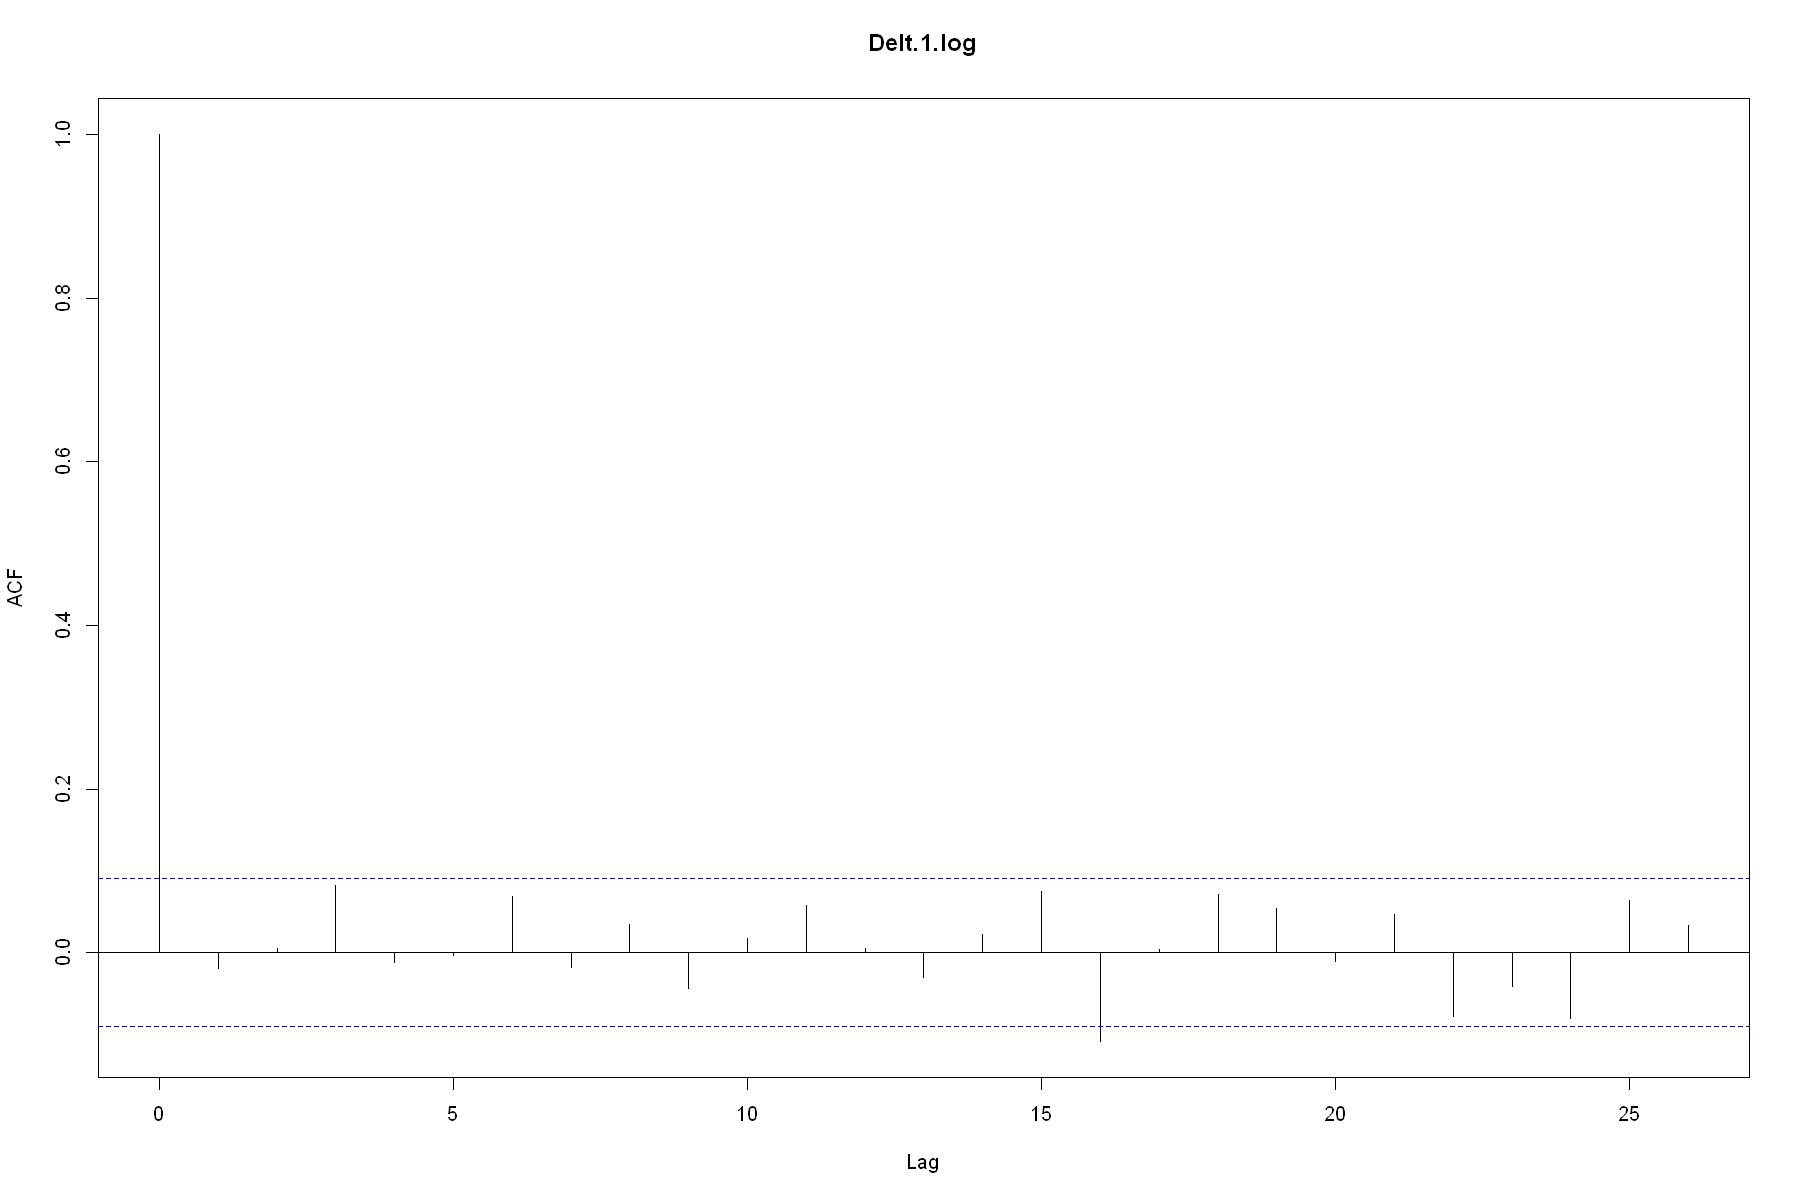

pacf plot: 

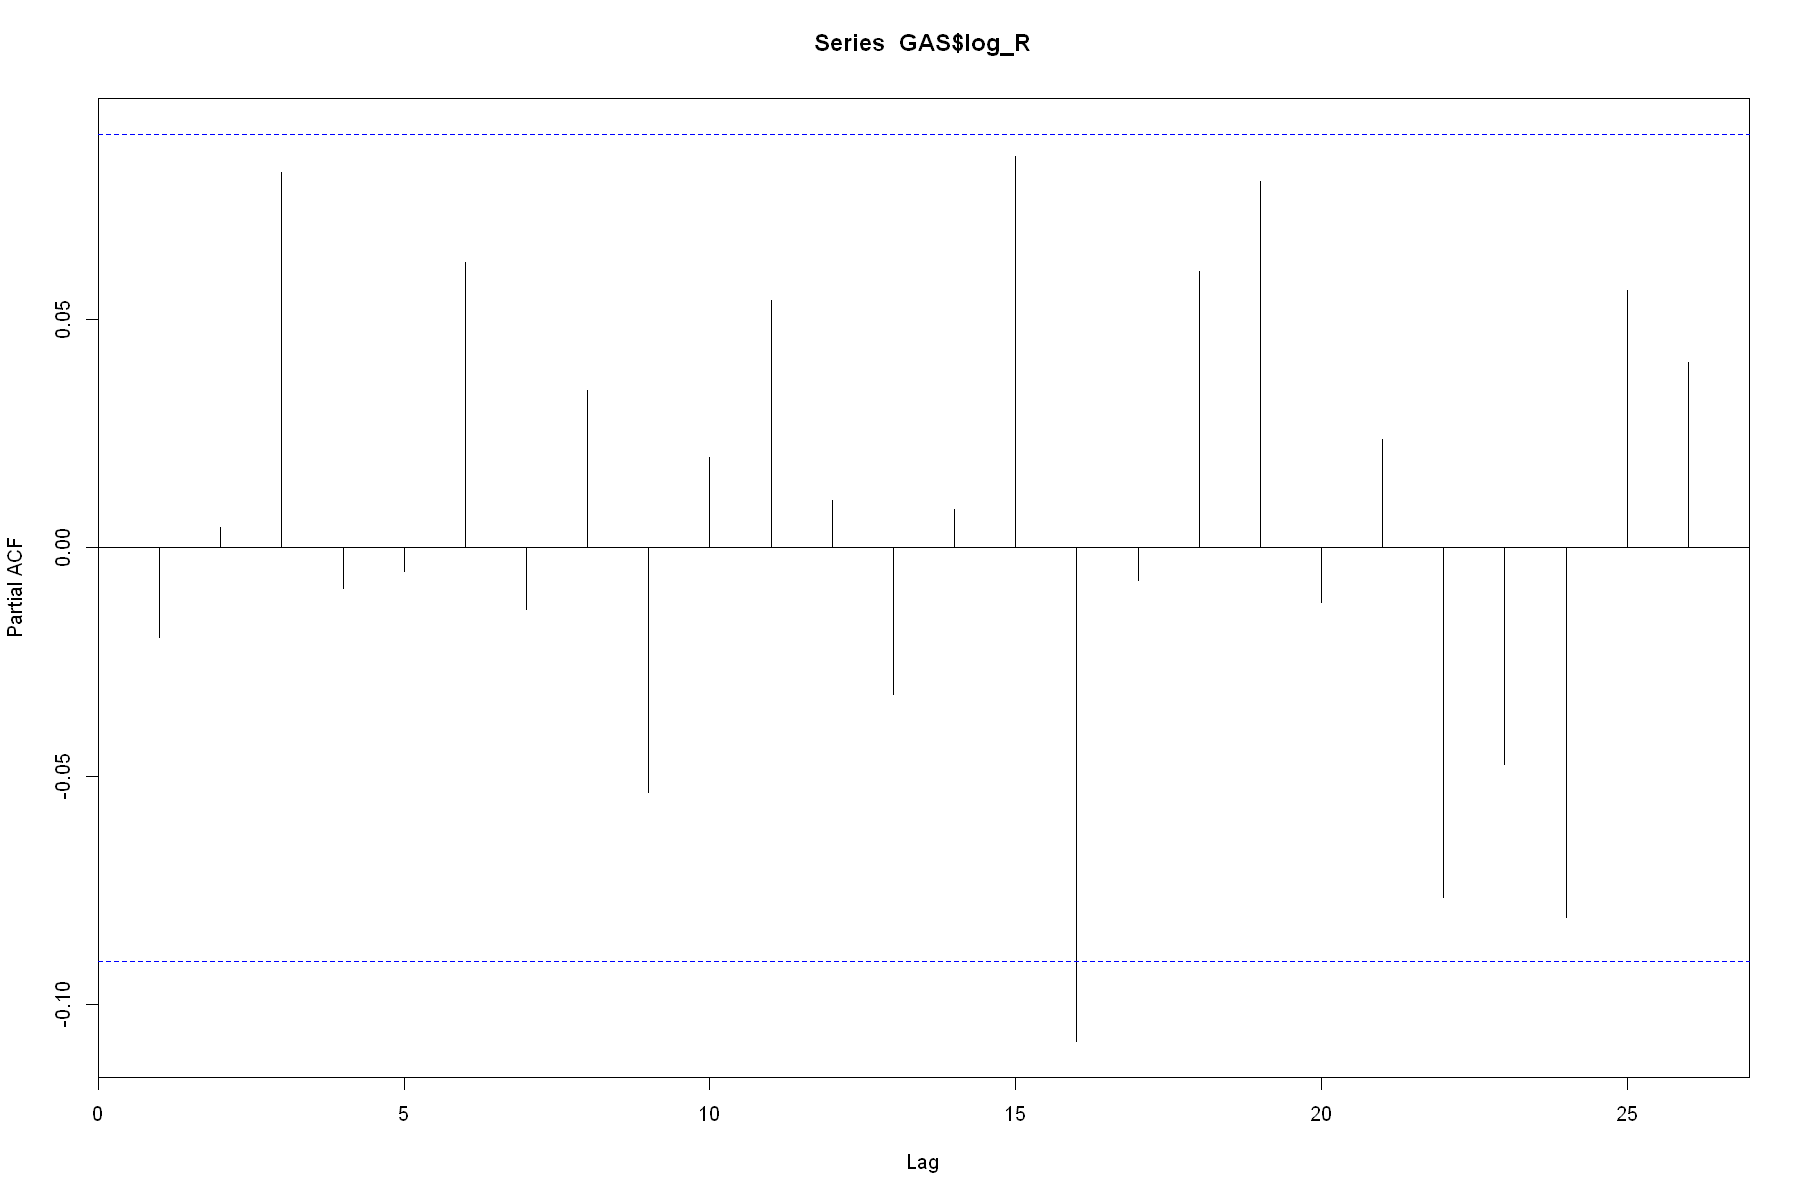

In [57]:
fig(15,10)
cat('acf plot: ')
acf(GAS$log_R)
pacf(GAS$log_R)
cat('pacf plot: ')

## 4 Volatility và GARCH:

In [71]:
spec1 <- ugarchspec(mean.model = list(armaOrder = c(2, 0)), variance.model = list(model= 'iGARCH', garchOrder = c(1,1)))
modell = ugarchfit(spec=spec1, data = GAS$log_R)

modell


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: iGARCH(1,1)
Mean Model	: ARFIMA(2,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.005141    0.001973  2.60533 0.009179
ar1    -0.029960    0.053999 -0.55483 0.579014
ar2     0.019103    0.050188  0.38062 0.703481
omega   0.000177    0.000067  2.64329 0.008210
alpha1  0.274736    0.060211  4.56290 0.000005
beta1   0.725264          NA       NA       NA

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.005141    0.001971  2.60802 0.009107
ar1    -0.029960    0.055301 -0.54177 0.587980
ar2     0.019103    0.060024  0.31825 0.750294
omega   0.000177    0.000126  1.41085 0.158288
alpha1  0.274736    0.120506  2.27986 0.022616
beta1   0.725264          NA       NA       NA

LogLike

## 5 VaR

### 5.1 Riskmetrics method :

Warning message in `setfixed<-`(`*tmp*`, value = as.list(pars)):
"Unrecognized Parameter in Fixed Values: beta1...Ignored"



*------------------------------------*
*       GARCH Model Forecast         *
*------------------------------------*
Model: iGARCH
Horizon: 1
Roll Steps: 0
Out of Sample: 0

0-roll forecast [T0=1971-04-15 07:00:00]:
      Series   Sigma
T+1 0.001153 0.07317



------------------------------- 
RiskMetrics VaR: 0.1207305 Or 12.07305 % 

 Risk Measures for selected probabilities: 
      prob       VaR        ES
[1,] 0.950 0.1203539 0.1509287
[2,] 0.990 0.1702189 0.1950137
[3,] 0.999 0.2261123 0.2463700
------------------------------- 
          0%          25%          50%          75%         100% 
-0.307225811 -0.018992915  0.001173476  0.031951921  0.202940324 
Historical VaR (Quantile Est VaR):  -0.06614053 Or 6.614053 % 
------------------------------- 
mean: 0.003149966 std: 0.05047002 
          0%          25%          50%          75%         100% 
-0.176613523 -0.030869604  0.003084091  0.037422476  0.191864444 

Monte Calor VaR:  0.0794939 Or 7.94939 %

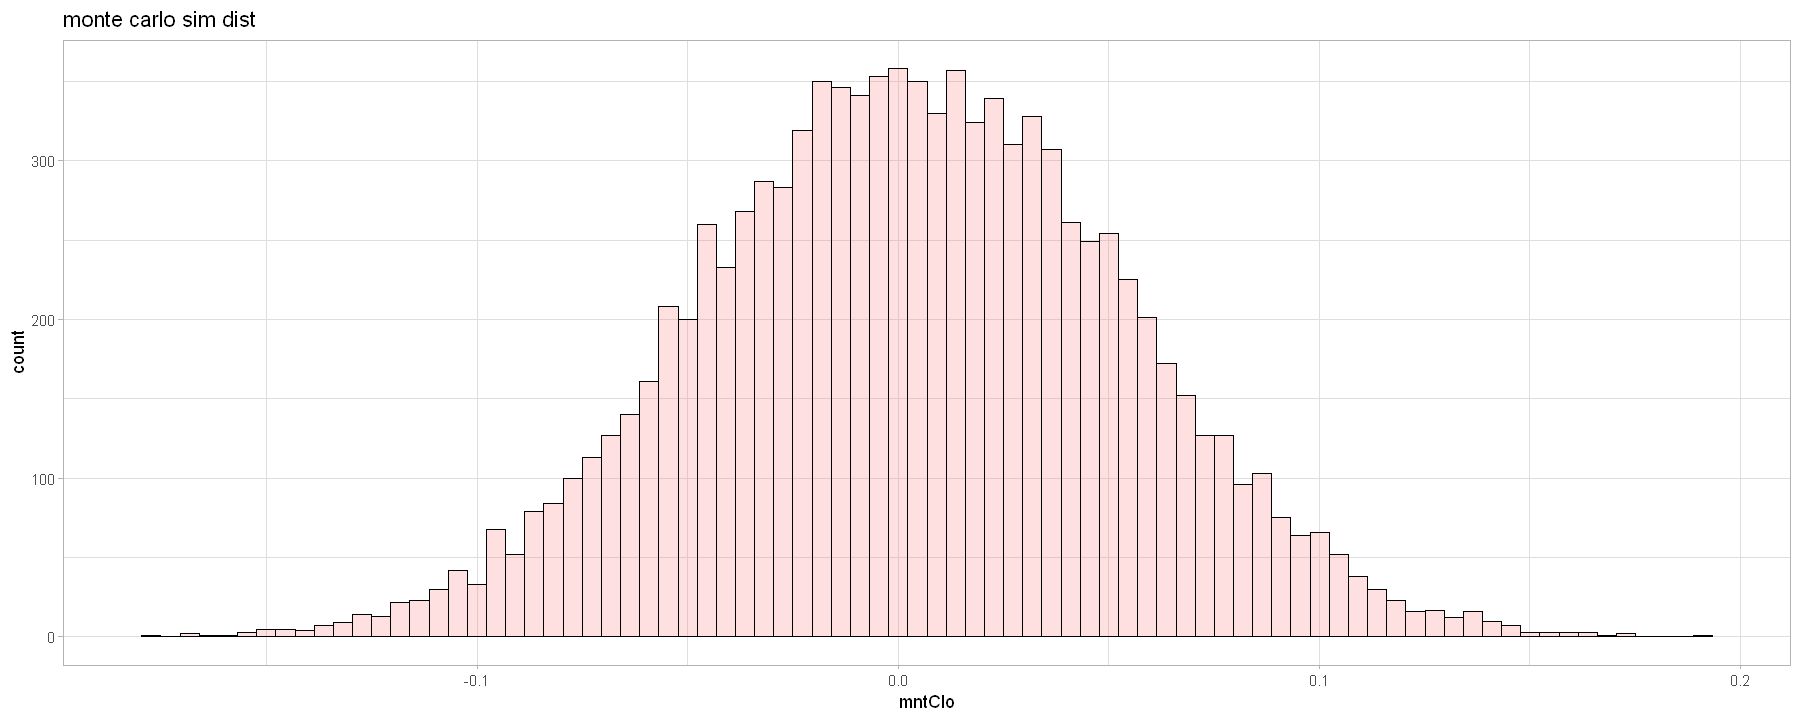

In [113]:
ugarchforecast(modell, n.ahead = 1)
cat('------------------------------- \n')
cat('RiskMetrics VaR:', (0 + 1.65 * 0.07317),'Or', ((0 + 1.65 * 0.07317) * 100), '% \n')
source('Rmeasure.R')
RMeasure(0, 0.07317)
cat('------------------------------- \n')
print(quantile(GAS$log_R))
cat('Historical VaR (Quantile Est VaR): ', quantile(GAS$log_R, 0.05), 'Or', quantile(GAS$neg_log_R, 0.95)*100, '% \n')
cat('------------------------------- \n')
mean <- mean(GAS$log_R)
std <- sd(GAS$log_R)
cat('mean:', mean, 'std:', std , "\n")

set.seed(1000)
mntClo <- rnorm(9999, mean=mean, sd = std)
print(quantile(mntClo))
cat("\n")
cat('Monte Calor VaR: ', quantile(-mntClo, 0.95), 'Or', quantile(-mntClo, 0.95)*100, '%')

fig(15,6)
p1 <- ggplot() + geom_histogram(color = 'black', aes(x=mntClo),alpha=0.2, 
                                fill='#FF6666' ,bins = 82) +  theme_light() + ggtitle('monte carlo sim dist')
p1

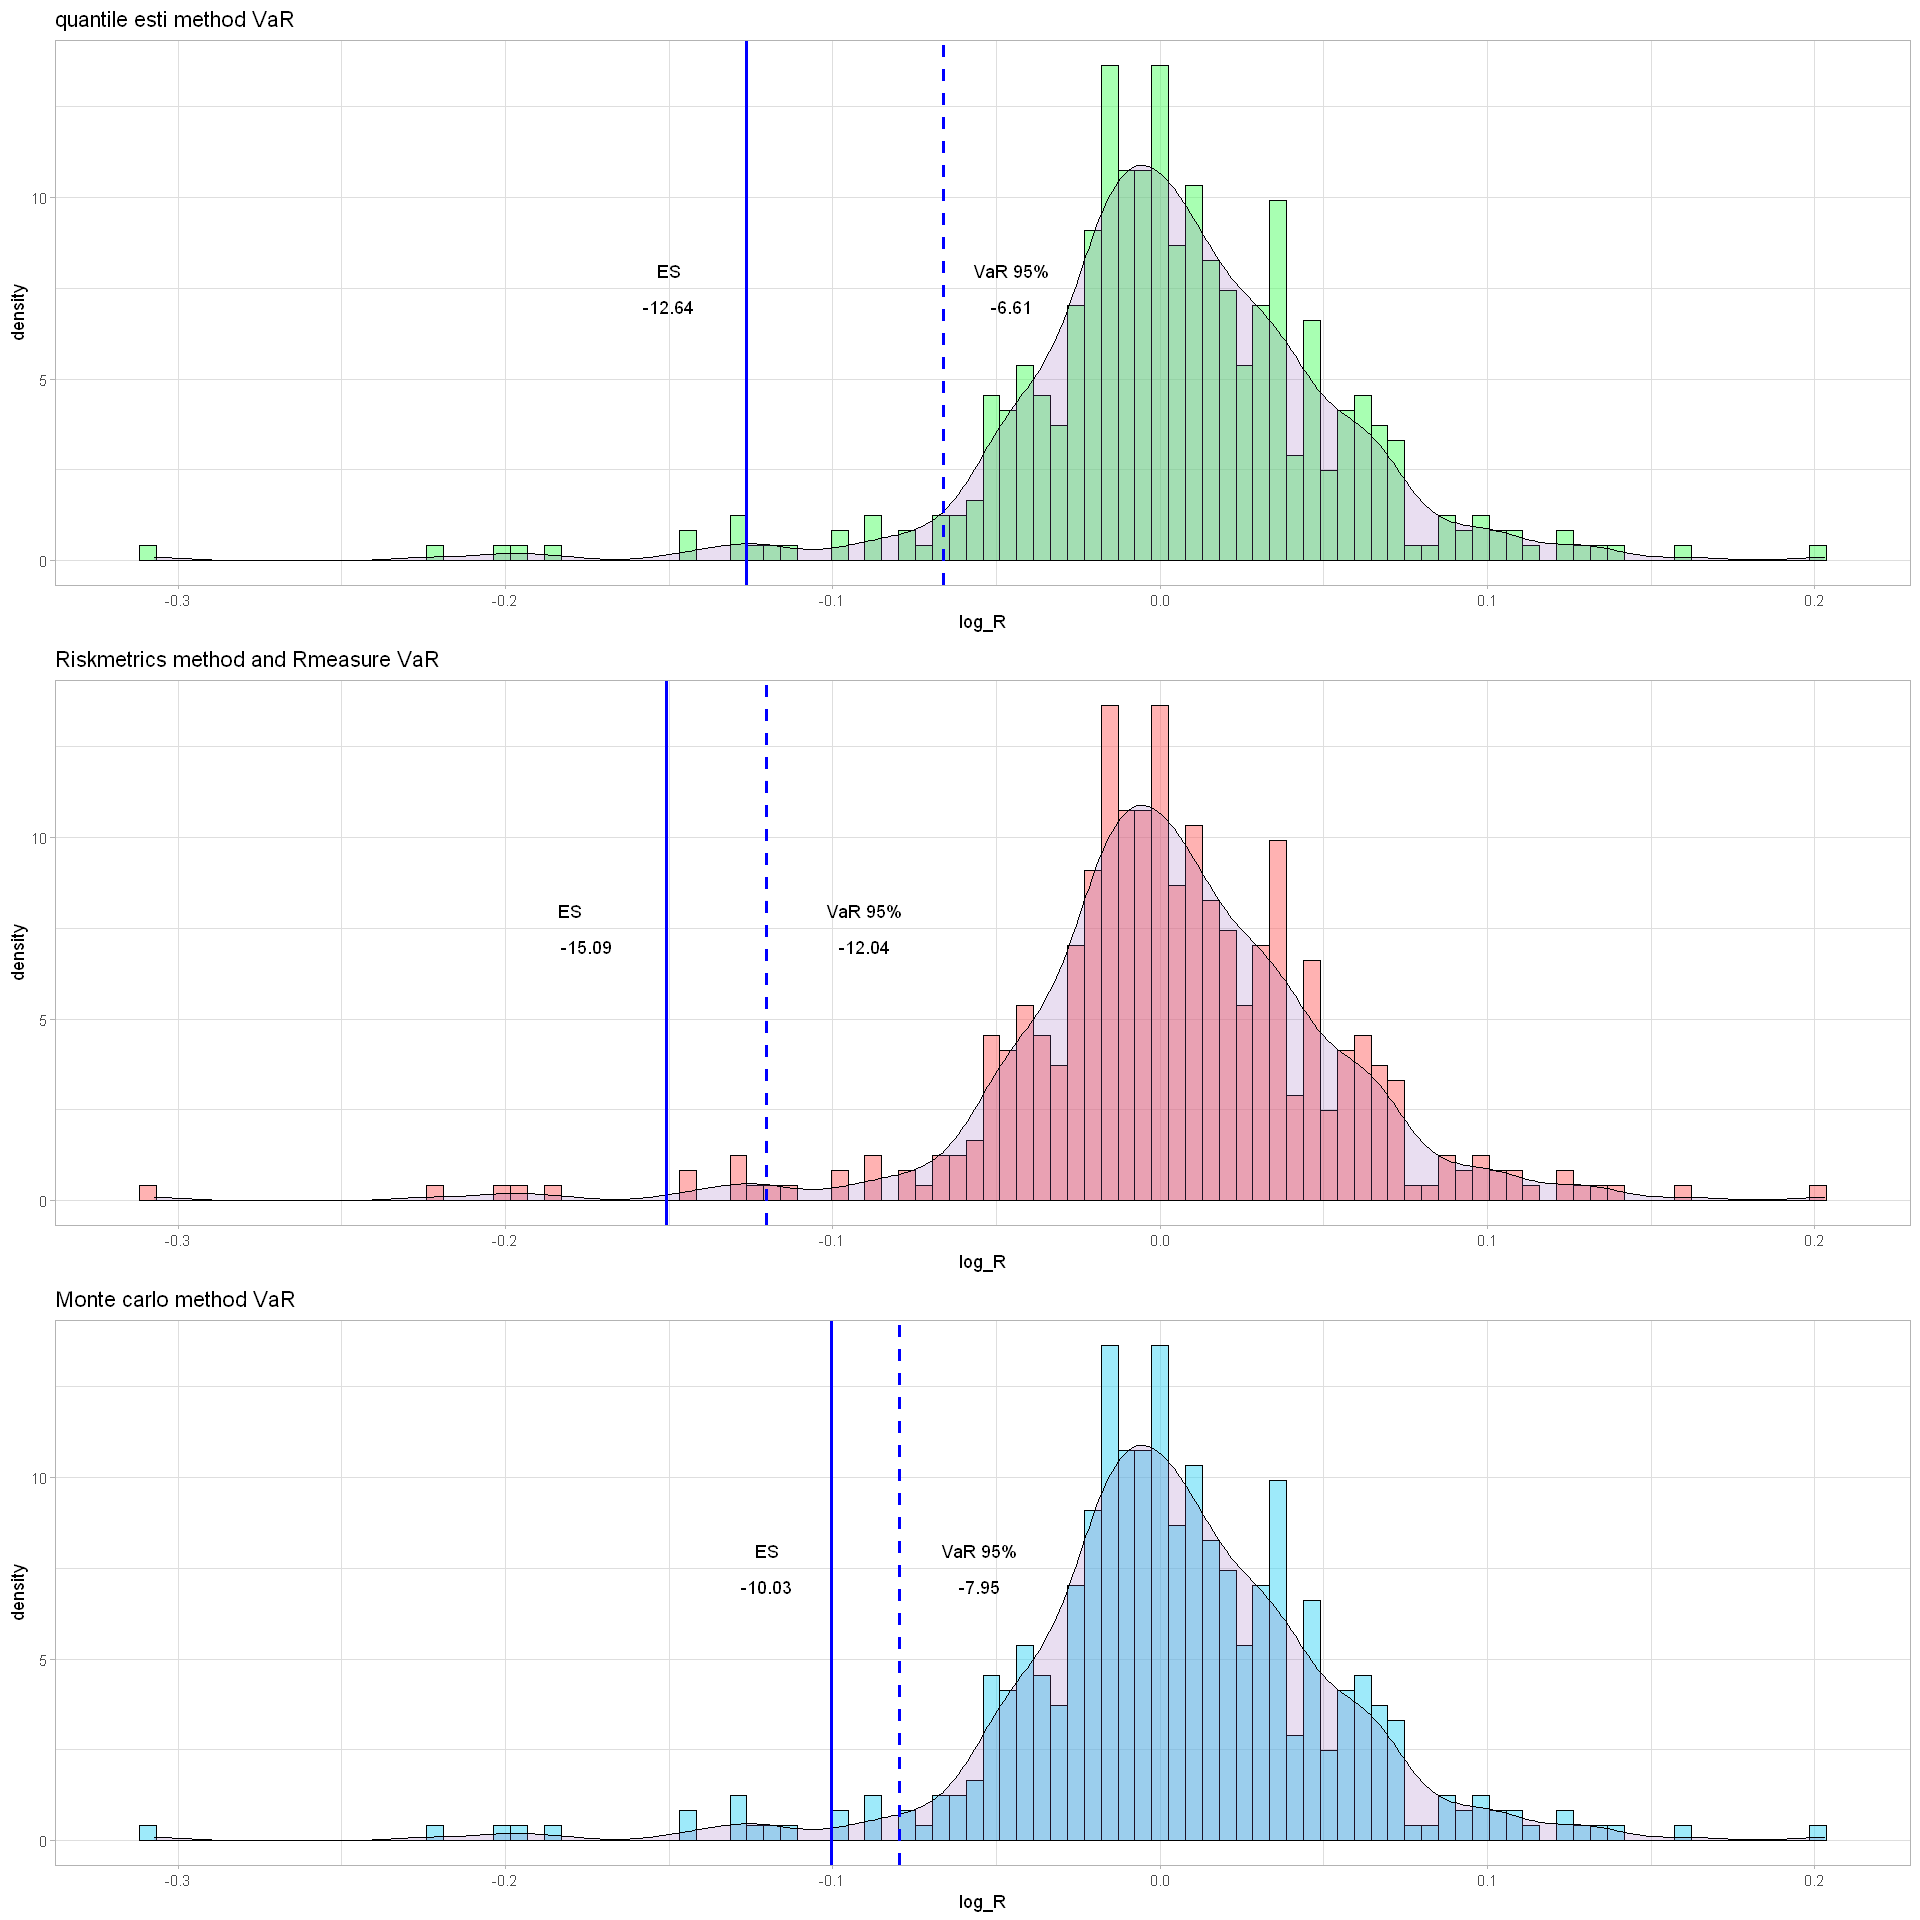

In [159]:
#####################
VaR.hist1 <- -0.1203539
ES.hist1 <- -0.1509287

p2 <- ggplot(GAS, aes(x=log_R)) + 
 geom_histogram(aes(y=..density..), colour="black", alpha=0.5, fill='#FF6666', bins = 100)+
 geom_density(alpha=.2, fill="#905cb8") + theme_light() 
p2 <- p2 + geom_vline(aes(xintercept = VaR.hist1), linetype = "dashed", size = 1, color = "blue") 
p2 <- p2 + geom_vline(aes(xintercept = ES.hist1), size = 1, color = "blue")
p2 <- p2+annotate("text", x = -0.090, y = 7, 
                  label = round(VaR.hist1*100, 2))+annotate("text", x=-0.09, y = 8, label = 'VaR 95%')
p2 <- p2 +annotate("text", x = -0.175, y = 7, 
                   label = round(ES.hist1*100, 2)) +annotate("text", x=-0.18, y = 8, label = 'ES')
p2 <- p2 + ggtitle('Riskmetrics method and Rmeasure VaR')
#######################
VaR.hist <- quantile(GAS$log_R, probs = 0.05, names = FALSE)
ES.hist <- mean(GAS$log_R[GAS$log_R < VaR.hist])

p <- ggplot(GAS, aes(x=log_R)) + 
 geom_histogram(aes(y=..density..), colour="black", alpha=0.5, fill='#52ff66', bins = 100)+
 geom_density(alpha=.2, fill="#905cb8") + theme_light() 
p <- p + geom_vline(aes(xintercept = VaR.hist), linetype = "dashed", size = 1, color = "blue") 
p <- p + geom_vline(aes(xintercept = ES.hist), size = 1, color = "blue")
p <- p + annotate("text", x = -0.045, y = 7, 
                  label = round(VaR.hist*100, 2)) + annotate("text", x = -0.045, y = 8, label = 'VaR 95%')
p <- p + annotate("text", x = -0.15, y = 7, 
                  label = round(ES.hist*100, 2)) + annotate("text", x = -0.15, y = 8, label = 'ES')
p <- p + ggtitle('quantile esti method VaR')

VaR.hist2 <- -quantile(-mntClo, probs = 0.95, names = FALSE)
ES.hist2 <- mean(mntClo[mntClo < VaR.hist2])
###########################
p3 <- ggplot(GAS, aes(x=log_R)) + 
 geom_histogram(aes(y=..density..), colour="black", alpha=0.5, fill='#3dd6f5', bins = 100)+
 geom_density(alpha=.2, fill="#905cb8") + theme_light() 
p3 <- p3 + geom_vline(aes(xintercept = VaR.hist2), linetype = "dashed", size = 1, color = "blue") 
p3 <- p3 + geom_vline(aes(xintercept = ES.hist2), size = 1, color = "blue")
p3 <- p3 + annotate("text", x = -0.055, y = 7, 
                    label = round(VaR.hist2*100, 2)) +annotate("text", x = -0.055, y = 8, label = 'VaR 95%')
p3 <- p3 + annotate("text", x = -0.12, y = 7, 
                    label = round(ES.hist2*100, 2)) +annotate("text", x = -0.12, y = 8, label = 'ES')
p3 <- p3 + ggtitle('Monte carlo method VaR')
##########################
fig(16, 16)
grid.arrange(p ,p2, p3, nrow = 3)

***